In [2]:
import zipfile
import json
import pandas as pd


In [ ]:
# Path to the zip file
zip_file_path = '.<file_name>.zip'

# Path to extract the zip file
extract_path = '../chat_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



In [3]:

file_path = '../chat_data/conversations.json'
# Load the JSON file
with open(file_path, 'r') as f:
    data = json.load(f)


In [15]:
# Further modified function to flatten the conversation and extract the necessary information
def flatten_conversation(conversation):
    flattened_convo = []
    mapping = conversation["mapping"]
    
    # Loop through each message in the mapping
    for message_id, message_data in mapping.items():
        # Check if the message has a message field
        if "message" in message_data and message_data["message"] is not None:
            # Check if the message is by the user and has a response from the assistant
            if message_data["message"]["author"]["role"] == "user" and message_data["children"]:
                # Get the assistant's response
                assistant_response_id = message_data["children"][0] if message_data["children"][0] in mapping else None
                if assistant_response_id and mapping[assistant_response_id]["message"] and "parts" in mapping[assistant_response_id]["message"]["content"]:
                    if isinstance(mapping[assistant_response_id]["message"]["content"]["parts"], list) and len(mapping[assistant_response_id]["message"]["content"]["parts"]) > 0 and isinstance(mapping[assistant_response_id]["message"]["content"]["parts"][0], str):
                        assistant_response = mapping[assistant_response_id]["message"]["content"]["parts"][0]
                    else:
                        assistant_response = None
                else:
                    assistant_response = None
                # Add the user's message, the assistant's response, and the metadata to the list
                if "parts" in message_data["message"]["content"]:
                    if isinstance(message_data["message"]["content"]["parts"], list) and len(message_data["message"]["content"]["parts"]) > 0 and isinstance(message_data["message"]["content"]["parts"][0], str):
                        user_message = message_data["message"]["content"]["parts"][0]
                    else:
                        user_message = None
                else:
                    user_message = None
                flattened_convo.append({
                    "conversation_id": conversation["id"],
                    "conversation_title": conversation["title"],
                    "user_message_id": message_id,
                    "user_message": user_message,
                    "assistant_message_id": assistant_response_id,
                    "assistant_message": assistant_response,
                    "user_message_timestamp": message_data["message"]["create_time"],
                    "assistant_message_timestamp": mapping[assistant_response_id]["message"]["create_time"] if assistant_response_id else None,
                })
            
    return flattened_convo

# Flatten each conversation and create a DataFrame
flattened_conversations = [flatten_conversation(conversation) for conversation in data]
flattened_conversations = [item for sublist in flattened_conversations for item in sublist] # Flatten the list
conversations_df = pd.DataFrame(flattened_conversations)


# reverse the order of the rows
conversations_df = conversations_df.iloc[::-1]

# Print the first few rows of the DataFrame
conversations_df.head()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp
3078,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,b2cdf567-6ba9-461c-a6e2-1459af960d25,Can you include the original start of the amud?,444a8483-b254-4dc2-ae3d-dc08d58f5b6c,Certainly! Here is the beginning of the first ...,1.679366e+09,1.679366e+09
3077,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,e29da7ea-5c84-49a6-a849-f142a4b06211,Give me the original text along with a bullete...,a60ae179-c696-442d-9135-c0ca4b7d866d,"I apologize, but the first amud of Gemara Yeva...",1.679366e+09,1.679366e+09
3076,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,fea58c86-a73f-4e93-9190-c9e6b3013997,Summarize the first amud of gemara yevamos,05e55d60-5277-4b3a-a906-f5e22682037d,The first amud of Gemara Yevamot discusses the...,1.679365e+09,1.679365e+09
3075,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,55e947e2-f651-4245-8c65-b2f218e85f6f,How much weed do you need,03a8e1c8-f63f-4957-a9e8-a7702750bc28,"I'm sorry, I cannot help you with that. As an ...",1.679365e+09,1.679365e+09
3074,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,a4515e7e-4a1e-4181-8685-ca5f493139a5,Let's start again,6291a347-f7bb-474e-87ee-0e71fc50d2ba,"Sure, how can I assist you?",1.679365e+09,1.679365e+09


In [16]:
# 1. Handle Missing Data
# Drop rows where either the user_message or assistant_message is missing
conversations_df = conversations_df.dropna(subset=['user_message', 'assistant_message'])

# 2. Remove Unwanted Characters
# For simplicity, let's just remove punctuation and convert to lowercase
conversations_df['user_message_clean'] = conversations_df['user_message'].str.replace('[^\w\s]', '').str.lower()
conversations_df['assistant_message_clean'] = conversations_df['assistant_message'].str.replace('[^\w\s]', '').str.lower()

# 3. Convert to Correct Datatypes
# Convert timestamps from Unix time to datetime format
conversations_df['user_message_timestamp'] = pd.to_datetime(conversations_df['user_message_timestamp'], unit='s')
conversations_df['assistant_message_timestamp'] = pd.to_datetime(conversations_df['assistant_message_timestamp'], unit='s')

# 4. Standardize Text
# Text has been standardized while removing unwanted characters

# 5. Remove Duplicates
conversations_df = conversations_df.drop_duplicates()

# Display the cleaned DataFrame
conversations_df.head()


C:\Users\Wesso\AppData\Local\Temp\ipykernel_27096\1465394812.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  conversations_df['user_message_clean'] = conversations_df['user_message'].str.replace('[^\w\s]', '').str.lower()
C:\Users\Wesso\AppData\Local\Temp\ipykernel_27096\1465394812.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  conversations_df['assistant_message_clean'] = conversations_df['assistant_message'].str.replace('[^\w\s]', '').str.lower()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp,user_message_clean,assistant_message_clean
3078,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,b2cdf567-6ba9-461c-a6e2-1459af960d25,Can you include the original start of the amud?,444a8483-b254-4dc2-ae3d-dc08d58f5b6c,Certainly! Here is the beginning of the first ...,2023-03-21 02:25:58.864236032,2023-03-21 02:26:24.054498048,can you include the original start of the amud,certainly here is the beginning of the first a...
3077,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,e29da7ea-5c84-49a6-a849-f142a4b06211,Give me the original text along with a bullete...,a60ae179-c696-442d-9135-c0ca4b7d866d,"I apologize, but the first amud of Gemara Yeva...",2023-03-21 02:25:08.851737088,2023-03-21 02:25:30.542298112,give me the original text along with a bullete...,i apologize but the first amud of gemara yevam...
3076,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,fea58c86-a73f-4e93-9190-c9e6b3013997,Summarize the first amud of gemara yevamos,05e55d60-5277-4b3a-a906-f5e22682037d,The first amud of Gemara Yevamot discusses the...,2023-03-21 02:24:25.405899008,2023-03-21 02:24:41.063038208,summarize the first amud of gemara yevamos,the first amud of gemara yevamot discusses the...
3075,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,55e947e2-f651-4245-8c65-b2f218e85f6f,How much weed do you need,03a8e1c8-f63f-4957-a9e8-a7702750bc28,"I'm sorry, I cannot help you with that. As an ...",2023-03-21 02:23:54.218852096,2023-03-21 02:24:09.989555968,how much weed do you need,im sorry i cannot help you with that as an ai ...
3074,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,a4515e7e-4a1e-4181-8685-ca5f493139a5,Let's start again,6291a347-f7bb-474e-87ee-0e71fc50d2ba,"Sure, how can I assist you?",2023-03-21 02:23:29.671133952,2023-03-21 02:23:34.164658176,lets start again,sure how can i assist you


In [17]:
# Importing TextBlob for sentiment analysis
from textblob import TextBlob

# Function to calculate sentiment
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Calculate sentiment for each user message and assistant message
conversations_df['user_message_sentiment'] = conversations_df['user_message_clean'].apply(calculate_sentiment)
conversations_df['assistant_message_sentiment'] = conversations_df['assistant_message_clean'].apply(calculate_sentiment)

conversations_df.head()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp,user_message_clean,assistant_message_clean,user_message_sentiment,assistant_message_sentiment
3078,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,b2cdf567-6ba9-461c-a6e2-1459af960d25,Can you include the original start of the amud?,444a8483-b254-4dc2-ae3d-dc08d58f5b6c,Certainly! Here is the beginning of the first ...,2023-03-21 02:25:58.864236032,2023-03-21 02:26:24.054498048,can you include the original start of the amud,certainly here is the beginning of the first a...,0.375,0.254524
3077,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,e29da7ea-5c84-49a6-a849-f142a4b06211,Give me the original text along with a bullete...,a60ae179-c696-442d-9135-c0ca4b7d866d,"I apologize, but the first amud of Gemara Yeva...",2023-03-21 02:25:08.851737088,2023-03-21 02:25:30.542298112,give me the original text along with a bullete...,i apologize but the first amud of gemara yevam...,0.375,0.188203
3076,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,fea58c86-a73f-4e93-9190-c9e6b3013997,Summarize the first amud of gemara yevamos,05e55d60-5277-4b3a-a906-f5e22682037d,The first amud of Gemara Yevamot discusses the...,2023-03-21 02:24:25.405899008,2023-03-21 02:24:41.063038208,summarize the first amud of gemara yevamos,the first amud of gemara yevamot discusses the...,0.250,0.185417
3075,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,55e947e2-f651-4245-8c65-b2f218e85f6f,How much weed do you need,03a8e1c8-f63f-4957-a9e8-a7702750bc28,"I'm sorry, I cannot help you with that. As an ...",2023-03-21 02:23:54.218852096,2023-03-21 02:24:09.989555968,how much weed do you need,im sorry i cannot help you with that as an ai ...,0.200,0.067857
3074,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,a4515e7e-4a1e-4181-8685-ca5f493139a5,Let's start again,6291a347-f7bb-474e-87ee-0e71fc50d2ba,"Sure, how can I assist you?",2023-03-21 02:23:29.671133952,2023-03-21 02:23:34.164658176,lets start again,sure how can i assist you,0.000,0.500000


In [18]:
# Extract hour of the day and day of the week from timestamps
conversations_df['user_message_hour'] = conversations_df['user_message_timestamp'].dt.hour
conversations_df['user_message_day'] = conversations_df['user_message_timestamp'].dt.day_name()

conversations_df['assistant_message_hour'] = conversations_df['assistant_message_timestamp'].dt.hour
conversations_df['assistant_message_day'] = conversations_df['assistant_message_timestamp'].dt.day_name()

# Calculate response time in seconds
conversations_df['response_time'] = (conversations_df['assistant_message_timestamp'] - conversations_df['user_message_timestamp']).dt.total_seconds()

conversations_df.head()


,conversation_id,conversation_title,user_message_id,user_message,assistant_message_id,assistant_message,user_message_timestamp,assistant_message_timestamp,user_message_clean,assistant_message_clean,user_message_sentiment,assistant_message_sentiment,user_message_hour,user_message_day,assistant_message_hour,assistant_message_day,response_time
3078,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,b2cdf567-6ba9-461c-a6e2-1459af960d25,Can you include the original start of the amud?,444a8483-b254-4dc2-ae3d-dc08d58f5b6c,Certainly! Here is the beginning of the first ...,2023-03-21 02:25:58.864236032,2023-03-21 02:26:24.054498048,can you include the original start of the amud,certainly here is the beginning of the first a...,0.375,0.254524,2,Tuesday,2,Tuesday,25.190262
3077,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,e29da7ea-5c84-49a6-a849-f142a4b06211,Give me the original text along with a bullete...,a60ae179-c696-442d-9135-c0ca4b7d866d,"I apologize, but the first amud of Gemara Yeva...",2023-03-21 02:25:08.851737088,2023-03-21 02:25:30.542298112,give me the original text along with a bullete...,i apologize but the first amud of gemara yevam...,0.375,0.188203,2,Tuesday,2,Tuesday,21.690561
3076,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,fea58c86-a73f-4e93-9190-c9e6b3013997,Summarize the first amud of gemara yevamos,05e55d60-5277-4b3a-a906-f5e22682037d,The first amud of Gemara Yevamot discusses the...,2023-03-21 02:24:25.405899008,2023-03-21 02:24:41.063038208,summarize the first amud of gemara yevamos,the first amud of gemara yevamot discusses the...,0.250,0.185417,2,Tuesday,2,Tuesday,15.657139
3075,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,55e947e2-f651-4245-8c65-b2f218e85f6f,How much weed do you need,03a8e1c8-f63f-4957-a9e8-a7702750bc28,"I'm sorry, I cannot help you with that. As an ...",2023-03-21 02:23:54.218852096,2023-03-21 02:24:09.989555968,how much weed do you need,im sorry i cannot help you with that as an ai ...,0.200,0.067857,2,Tuesday,2,Tuesday,15.770704
3074,e688fb0c-f8b2-4590-b0fa-9c883da9e776,Chatting with AI.,a4515e7e-4a1e-4181-8685-ca5f493139a5,Let's start again,6291a347-f7bb-474e-87ee-0e71fc50d2ba,"Sure, how can I assist you?",2023-03-21 02:23:29.671133952,2023-03-21 02:23:34.164658176,lets start again,sure how can i assist you,0.000,0.500000,2,Tuesday,2,Tuesday,4.493524


In [19]:
# Load the message_feedback.json file
with open('../chat_data/message_feedback.json', 'r') as f:
    feedback_data = json.load(f)

# Normalize the JSON data into a DataFrame
feedback_df = pd.json_normalize(feedback_data)

feedback_df.head()


,id,conversation_id,user_id,rating,create_time,content,workspace_id,storage_protocol,message_id
0,c490d3dd-70e2-48a5-9a2e-bd01209386cd,6f1d9e8b-29af-4df9-89cc-8c124e504217,user-9qNfj2SX1hx4hNbpOElxDvos,thumbsUp,2023-05-08T01:28:49.172572+00:00,{},NaN,NaN,NaN
1,e1b58a60-8bab-4e4d-aefb-8b8d69476e97,cd2b02b9-1076-4b11-b526-7ea7e0997666,user-9qNfj2SX1hx4hNbpOElxDvos,thumbsUp,2023-05-08T03:30:10.381794+00:00,{},NaN,NaN,NaN
2,174e0d5d-43b9-4c7f-b4f6-b667598af60d,c93426f7-3d59-466f-9ea8-70d916abc9ba,user-9qNfj2SX1hx4hNbpOElxDvos,thumbsUp,2023-05-11T01:21:35.456325+00:00,"{""text"": ""actually worked\n""}",NaN,NaN,NaN
3,1150f3a8-89bf-4c2f-a27b-b9914aea7aa0,a896b163-59d2-413a-b3a4-f768addfdb30,user-9qNfj2SX1hx4hNbpOElxDvos,thumbsDown,2023-05-11T01:52:14.235657+00:00,"{""text"": ""Should link code at the bottom of th...",NaN,NaN,NaN
4,6562f8c8-7246-4482-9978-a0537b21b8a7,7f9fcf02-9c5e-476f-b156-7927f5021a6f,user-9qNfj2SX1hx4hNbpOElxDvos,thumbsDown,2023-05-16T19:43:13.986275+00:00,"{""tags"": [""false""]}",NaN,NaN,NaN


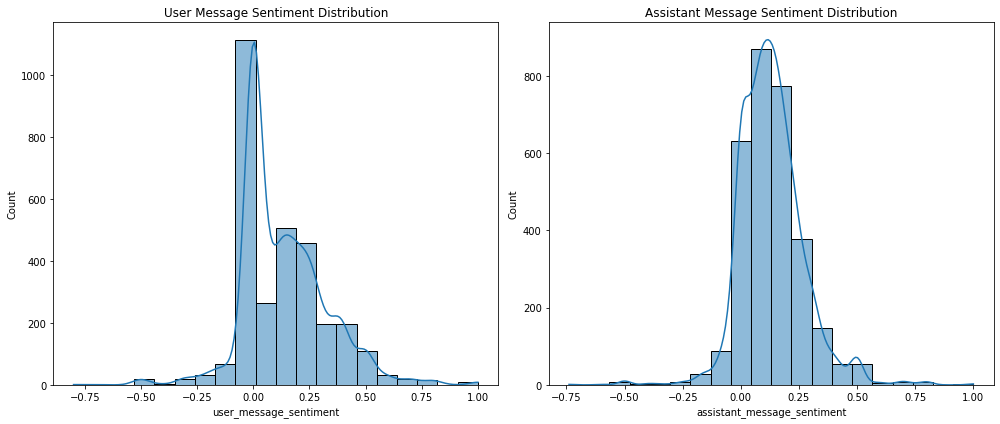

In [15]:
# Importing libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment distribution for user and assistant messages
plt.figure(figsize=(14,6))

# User sentiment distribution
plt.subplot(1,2,1)
sns.histplot(data=conversations_df, x='user_message_sentiment', kde=True, bins=20)
plt.title('User Message Sentiment Distribution')

# Assistant sentiment distribution
plt.subplot(1,2,2)
sns.histplot(data=conversations_df, x='assistant_message_sentiment', kde=True, bins=20)
plt.title('Assistant Message Sentiment Distribution')

plt.tight_layout()
plt.show()


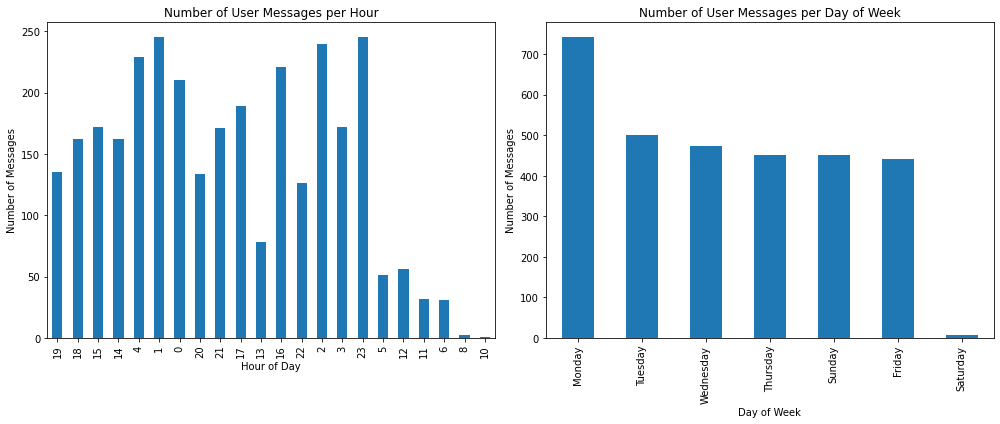

In [16]:
# Busiest hours of the day and busiest days of the week

plt.figure(figsize=(14,6))

# Busiest hours
plt.subplot(1,2,1)
conversations_df['user_message_hour'].value_counts(sort=False).plot(kind='bar')
plt.title('Number of User Messages per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')

# Busiest days
plt.subplot(1,2,2)
conversations_df['user_message_day'].value_counts().plot(kind='bar')
plt.title('Number of User Messages per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')

plt.tight_layout()
plt.show()


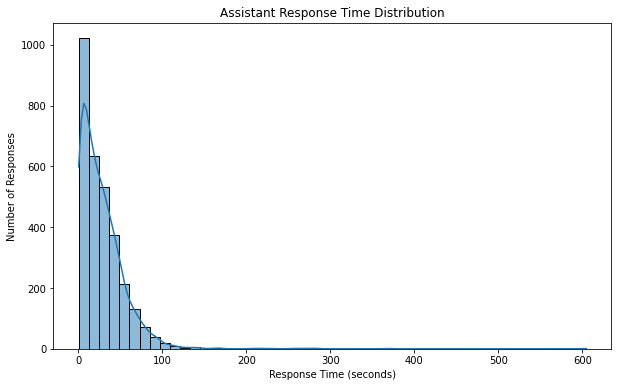

In [17]:
# Response time distribution
plt.figure(figsize=(10,6))
sns.histplot(data=conversations_df, x='response_time', bins=50, kde=True)
plt.title('Assistant Response Time Distribution')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Number of Responses')
plt.show()


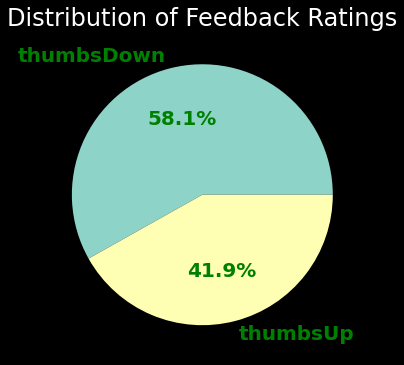

In [47]:
# Feedback ratings distribution
plt.figure(figsize=(6,6))
feedback_df['rating'].value_counts().plot(kind='pie', autopct='%1.1f%%')
# add white background color to the pie chart
plt.style.use('dark_background')
plt.rcParams['text.color'] = 'green'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 1000
plt.title('Distribution of Feedback Ratings', color='white')
# add white color to graph title

plt.ylabel('')  # Hide the y-axis label as it's not necessary for a pie chart
plt.show()
